In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import make_scorer, mean_squared_log_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Predictive Analysis utilizing XGBRegressor

In [2]:
df = pd.read_excel('storiesDB.xlsx')
feature_columns = [col for col in df.select_dtypes(include='number').columns.tolist() if col not in ['num_comments', 'upvotes', 'downvotes', 'upvote_ratio', 'Unnamed: 0']]
features = df[feature_columns]

#Log applied to normalized upvotes
target = df['upvotes'].apply(np.log1p) 

In [3]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 500, 700],
    'alpha': [0, 1],
    'lambda': [1, 2],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.9]
}

In [4]:
cv = RepeatedKFold(n_splits=3, n_repeats=2, random_state=42)
msle_scorer = make_scorer(mean_squared_log_error, greater_is_better=False)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring=msle_scorer, cv=cv, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 6 folds for each of 864 candidates, totalling 5184 fits


GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=3, random_state=42),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=No...
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'alpha': [0, 1], 'gamma': [0, 0.1, 0.2],
                         'lambda': [1, 2], 'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 500, 700],
                         'subsample': [0.7, 0.9]},
             scoring=make_scorer(mean_squared_log_error, greater_is_better=False, response_method='predict'),
             verbose=2)

In [5]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_test_transform = np.expm1(y_test)
y_pred_transform = np.expm1(y_pred)

In [6]:
mse = mean_squared_error(y_test_transform, y_pred_transform)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_transform, y_pred_transform)
mape = mean_absolute_percentage_error(y_test_transform, y_pred_transform)

In [7]:
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

Best Parameters: {'alpha': 1, 'gamma': 0.1, 'lambda': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 700, 'subsample': 0.7}
Root Mean Squared Error (RMSE): 12482.622114296724
Mean Absolute Error (MAE): 6366.253131795908
Mean Absolute Percentage Error: 861143445823981.4


In [8]:
feature_importances = best_model.feature_importances_
sorted_idx = np.argsort(feature_importances)

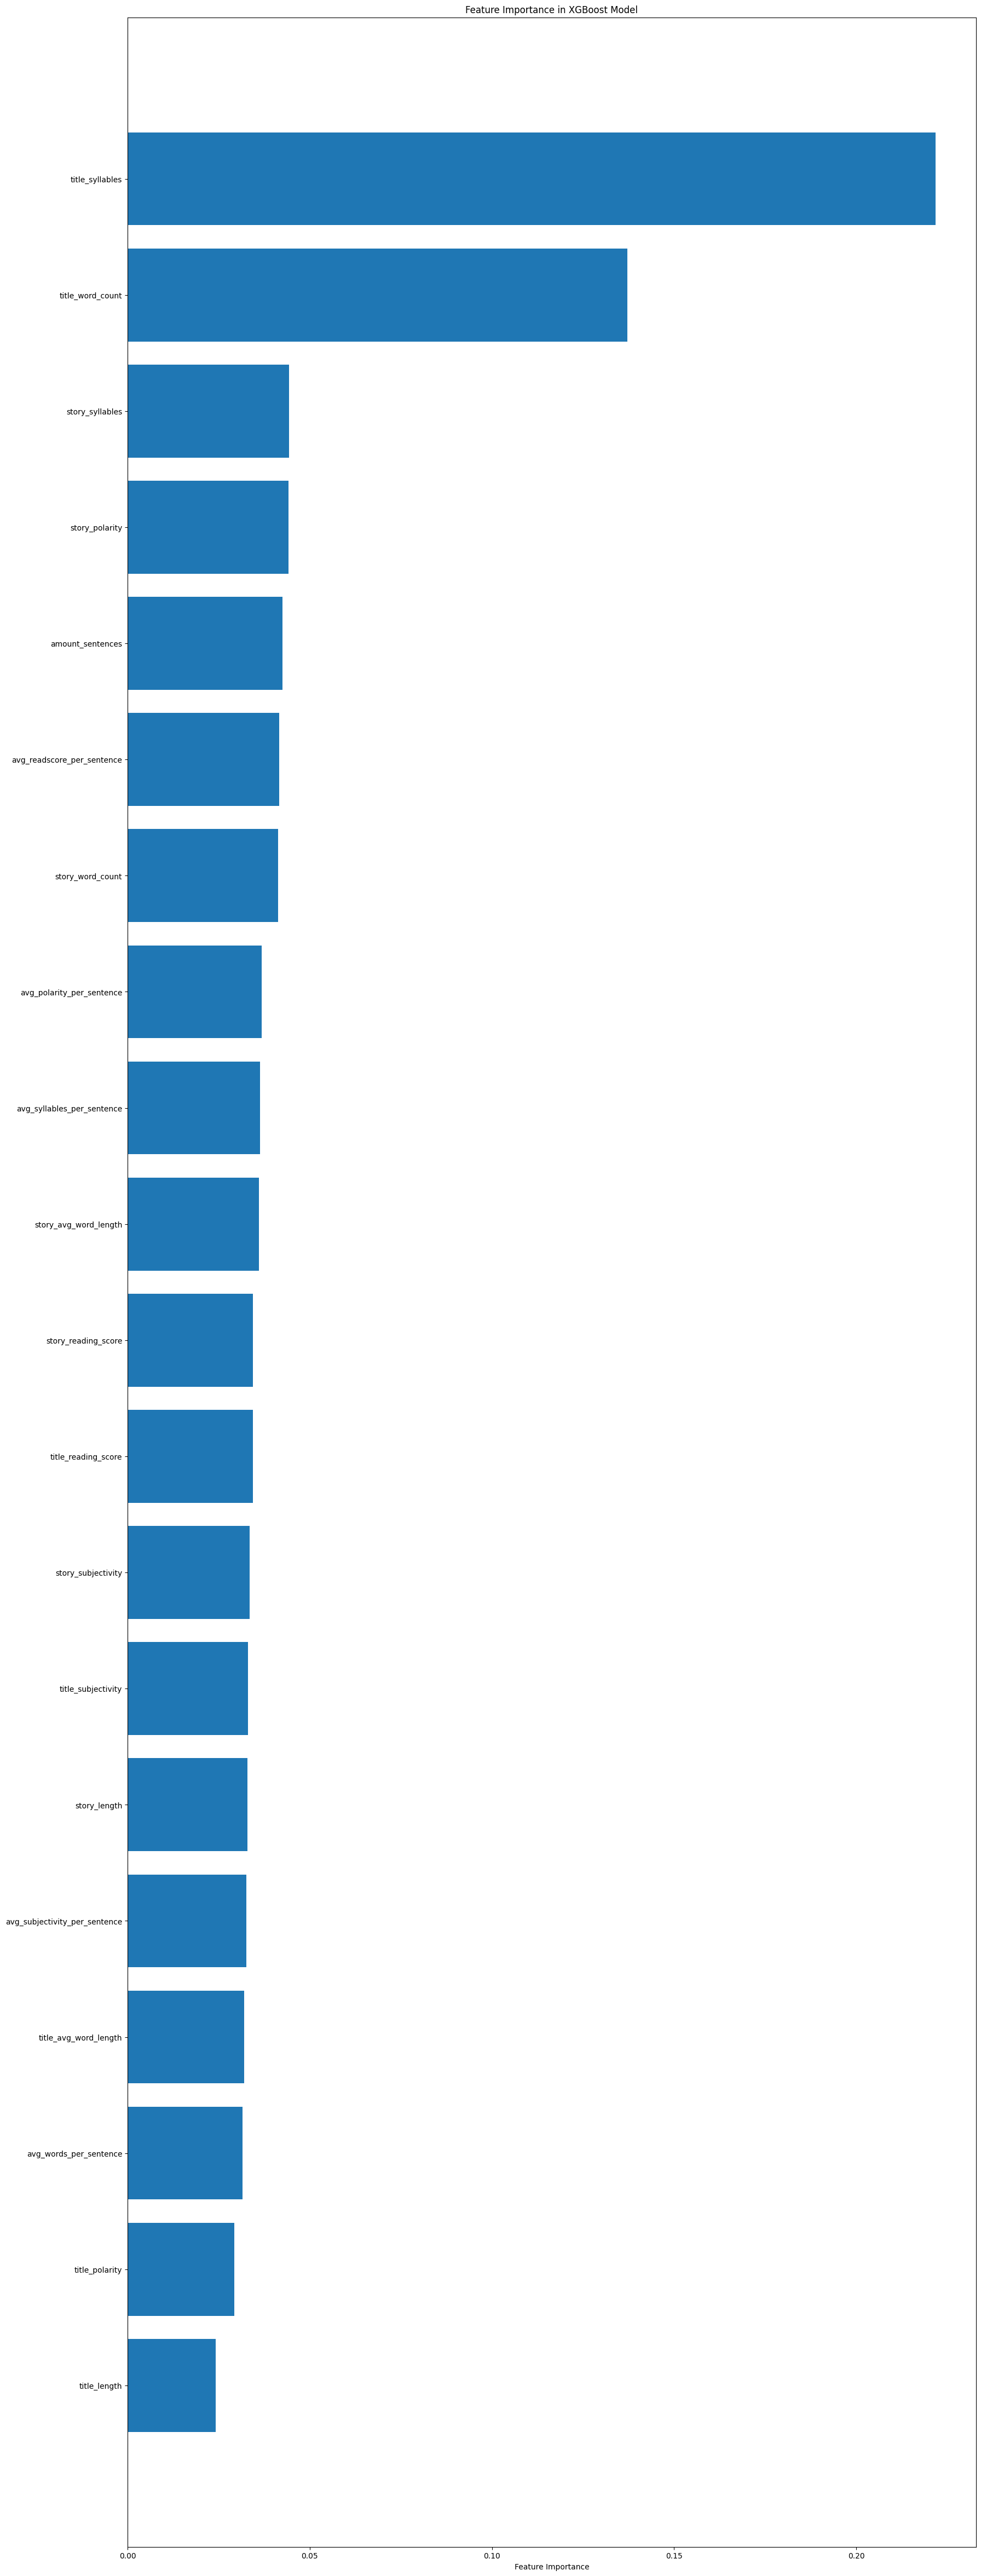

In [9]:
plt.figure(figsize=(20, 60))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features.columns)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in XGBoost Model')
plt.show()

In [10]:
from joblib import dump

dump(best_model, 'stories_model.joblib')

['stories_model.joblib']